# Calculate phase dependent modulation of AP generation in response to spatially diffuse or concentrated poisson excitation and rhythmic inhibition

The simulations had either: 
1. Rhythmic inhibition at the soma (64 Hz) or dendrites (16 Hz) 
2. Diffuse or concentrated synaptic excitation at and dendrites

Here we calculate the cross-correlation between action potentials and input on spatially diffuse or concentrated synapses. These are stratified by:
1. Phase (peak or trough) of the inhibitory rhythm
2. Frequency of rhythm

The output of this script are...

In [1]:
import sys
import os
sys.path.append('..') # have to do this for relative imports in jupyter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.linear_model import LogisticRegression
from scipy.special import expit
from src.load_spike_h5 import load_spike_h5
from src.load_spike_aux_h5 import load_spike_aux_h5

### 1.1 Simulation constants and analysis windows

In [2]:
samps_per_ms = 10 # samples per millisecond
fs = 10000 # sampling frequency
sim_win = [0, 9000000] # beginning and start points of simulation in samples
cc_bin = samps_per_ms * 1 # bin size for cross-correlation in samples
cc_win_16 = [-499, 500] # number of lags for cross-correlation at 16 Hz inhibition
cc_win_64 = [-499, 500] # number of lags for cross-correlation at 64 Hz inhibition
cc_win_poiss = [-499, 500] # number of lags for cross-correlation with poisson inhibition

### 1.2 List files to be processed

In [3]:
# locate simulation files
dir_list = [{'RootDir': 'Z:\\DendOscSub\\output_clust_16Hz_conc_apical\\long',
             'InhibType': '16', 'ExcType': 'conc', 'ExcLoc': 'apical'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_16Hz_conc_basal\\long',
             'InhibType': '16', 'ExcType': 'conc', 'ExcLoc': 'basal'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_16Hz_diff\\long',
                'InhibType': '16', 'ExcType': 'diff', 'ExcLoc': 'apical'},
            #{'RootDir': 'Z:\\DendOscSub\\output_clust_16Hz_lessdiffuse_apical\\long',
            #    'InhibType': '16', 'ExcType': 'lessdiffuse', 'ExcLoc': 'apical'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_64Hz_conc_apical\\long',
                'InhibType': '64', 'ExcType': 'conc', 'ExcLoc': 'apical'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_64Hz_conc_basal\\long',
                'InhibType': '64', 'ExcType': 'conc', 'ExcLoc': 'basal'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_64Hz_diff\\long',
                'InhibType': '64', 'ExcType': 'diff', 'ExcLoc': 'apical'},
            #{'RootDir': 'Z:\\DendOscSub\\output_clust_64Hz_lessdiffuse_apical\\long',
            #    'InhibType': '64', 'ExcType': 'lessdiffuse', 'ExcLoc': 'apical'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_poiss_conc_apical\\long',
                'InhibType': 'poiss', 'ExcType': 'conc', 'ExcLoc': 'apical'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_poiss_conc_basal\\long',
                'InhibType': 'poiss', 'ExcType': 'conc', 'ExcLoc': 'basal'},
            {'RootDir': 'Z:\\DendOscSub\\output_clust_poiss_diff\\long',
                'InhibType': 'poiss', 'ExcType': 'diff', 'ExcLoc': 'apical'},]
            #{'RootDir': 'Z:\\DendOscSub\\output_clust_poiss_lessdiffuse_apical\\long',
            #    'InhibType': 'poiss', 'ExcType': 'lessdiffuse', 'ExcLoc': 'apical'}]

sim_df = pd.DataFrame(dir_list)

### 1.3 Generate inhibitory rhythm time series

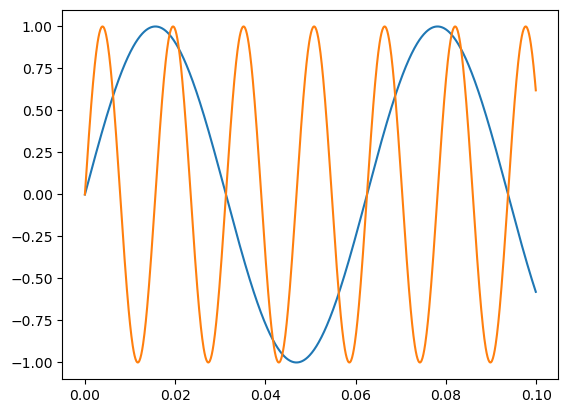

In [4]:
# generate phase time series for inhibitory afferents
t_ser = np.arange(sim_win[0], sim_win[1], 1) / fs # seconds
sin_16_ser = np.sin(t_ser*16*2*np.pi)
sin_64_ser = np.sin(t_ser*64*2*np.pi)

fig, ax = plt.subplots()
ax.plot(t_ser[0:1000],sin_16_ser[0:1000])
ax.plot(t_ser[0:1000],sin_64_ser[0:1000])
plt.show()

In [13]:
sim_df

,RootDir,InhibType,ExcType,ExcLoc
0,Z:\DendOscSub\output_clust_16Hz_conc_apical\long,16,conc,apical
1,Z:\DendOscSub\output_clust_16Hz_conc_basal\long,16,conc,basal
2,Z:\DendOscSub\output_clust_16Hz_diff\long,16,diff,apical
3,Z:\DendOscSub\output_clust_64Hz_conc_apical\long,64,conc,apical
4,Z:\DendOscSub\output_clust_64Hz_conc_basal\long,64,conc,basal
5,Z:\DendOscSub\output_clust_64Hz_diff\long,64,diff,apical
6,Z:\DendOscSub\output_clust_poiss_conc_apical\long,poiss,conc,apical
7,Z:\DendOscSub\output_clust_poiss_conc_basal\long,poiss,conc,basal
8,Z:\DendOscSub\output_clust_poiss_diff\long,poiss,diff,apical


### Test logistic regression

In [5]:
spk_pts = load_spike_h5(os.path.join(sim_df.loc[6,'RootDir'],'spikes.h5'))
pre_pts = load_spike_aux_h5(os.path.join(sim_df.loc[6,'RootDir'], 'exc_stim_aux_spikes2.h5'))

# count spk_pts in 1 ms bins
spk_bins = np.histogram(spk_pts, bins=np.arange(sim_win[0], sim_win[1], samps_per_ms))[0]
pre_bins = np.histogram(pre_pts, bins=np.arange(sim_win[0], sim_win[1], samps_per_ms))[0]

In [11]:
spk_bins.shape

(899999,)

(0.0, 10000.0)

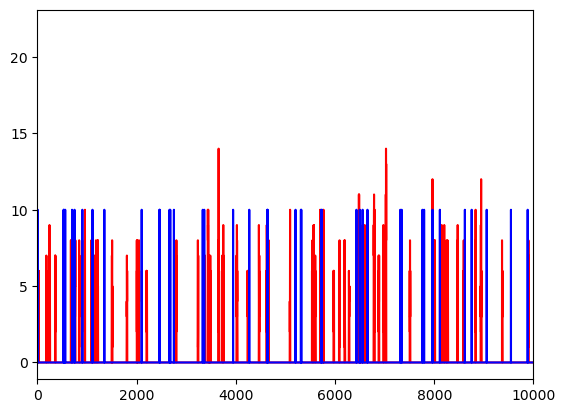

In [6]:
# plot spk_bins and pre_bins on same axes
fig, ax = plt.subplots()
ax.plot(pre_bins, color='r')
ax.plot(spk_bins*10, color='b')
ax.set_xlim(0,10000)

(array([2.3322e+04, 2.8076e+04, 1.7110e+04, 5.8940e+03, 1.4900e+03,
        4.7400e+02, 1.2800e+02, 3.0000e+01, 9.0000e+00, 3.0000e+00]),
 array([ 1. ,  3.1,  5.2,  7.3,  9.4, 11.5, 13.6, 15.7, 17.8, 19.9, 22. ]),
 <BarContainer object of 10 artists>)

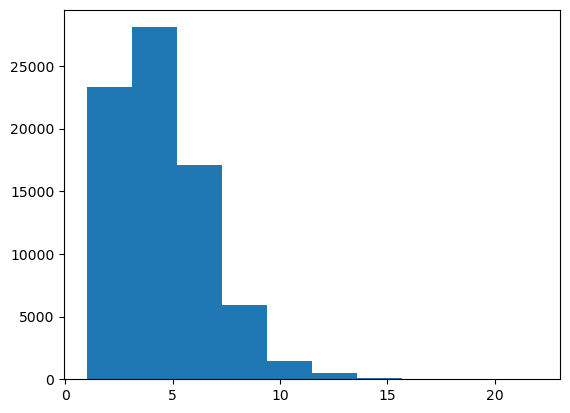

In [9]:
fig, ax = plt.subplots()
ax.hist(pre_bins[pre_bins!=0])


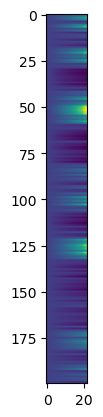

In [16]:
fig, ax = plt.subplots()
lr_curve = []
for lag in range(-100,100,1):
    # perform the regression
    logreg = LogisticRegression()
    if lag < 0:
        logreg.fit(pre_bins[(-lag):(100000-lag)].reshape(-1,1), spk_bins[0:100000])
    else:
        logreg.fit(pre_bins[0:100000].reshape(-1,1), spk_bins[lag:(100000+lag)])

    # plot the regression
    uniq_pre_bins = np.unique(pre_bins).reshape(-1,1)

    lr_curve.append(expit((uniq_pre_bins * logreg.coef_) + logreg.intercept_).ravel())

lr_curve = np.array(lr_curve)
ax.imshow(lr_curve)
#ax.scatter(pre_bins, spk_bins, marker='.')


In [10]:
uniq_pre_bins

array([[ 0],
       [ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10],
       [11],
       [12],
       [13],
       [14],
       [15],
       [16],
       [17],
       [18],
       [19],
       [21],
       [22]], dtype=int64)